In [1]:
import numpy as np # linear algebra
#import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import torch
import matplotlib.pyplot as plt
import matplotlib
from torch.utils.data import DataLoader, Dataset, random_split
import torch.nn as nn
import copy
import torch
from torchvision import transforms
from torch.optim import lr_scheduler
import os
import math
import numpy as np
from sklearn.manifold import TSNE
from sklearn.metrics import confusion_matrix
import itertools
from sklearn.preprocessing import MinMaxScaler, QuantileTransformer
from skimage import io
import umap
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


# Data preparation

In [2]:
class FaceDataset(Dataset):

    def __init__(self, image_dir, transform=None):
        
        """Function to load images into Tensor
            Args: 
                - image_dir : directory of images
                - Return : a dictonary with images and labels
        """
        self.image_dir = image_dir
        self.image_dict = self.load_image()
        self.transform = transform


    def __len__(self) :
        return len(self.image_dict["label"])


    def __getitem__(self, index) :
        
        
        path = torch.from_numpy(io.imread(self.image_dict["img_dir"][index],
                                         as_gray=True).astype(np.float32)).unsqueeze(0)
        label_bin = self.image_dict["label_bin"][index]
        label_to_token = self.image_dict["label"][index]

        if self.transform:
            path = self.transform(path)
        
        return path, label_bin, label_to_token


    def load_image(self) :
        img_dict = {"img_dir" : [], "label" : [], 'label_bin':[]}
        label_to_int = {"real":0,"easy":1,"mid_":2,"hard":3}
        for root, dirs, files in os.walk(self.image_dir):
            for img in files:
                img_dict["img_dir"].append(os.path.join(root, img))
                
                img_dict["label"].append(label_to_int[img[:4]])
                if img[:4] != 'real':
                    img_dict["label_bin"].append(1.0)
                else:
                    img_dict["label_bin"].append(0.0)
        img_dict["label_bin"] = torch.tensor(img_dict["label_bin"],dtype=torch.float32)
        img_dict["label"] = torch.tensor(img_dict["label"],dtype=torch.float32)
        return img_dict

In [3]:
def getActivation(name):
  # the hook signature
  def hook(model, input, output):
    activation[name] = output.detach()
  return hook

def plot_embeddings(X, y, title):
    
    y = y.astype(int)
    X = QuantileTransformer().fit_transform(X)
    
    plt.figure(figsize = (10,10))
    for i in range(X.shape[0]):        
        plt.text(X[i, 0],
                 X[i, 1],
                 str(y[i]),
                 color=plt.cm.Dark2(y[i]),
                 fontdict={"weight": "bold", "size": 9})
    plt.xticks([]), plt.yticks([])
    plt.title(title, fontsize=16)
    plt.show()
    
    return

In [4]:
def split_data(datas, train_size=0.8):
    
    """ Function to split data in training, valid and testing
        Args:   data torch Dataset
                train_size the training data size """
    training_size = int(train_size*len(datas))
    train_data, test_data = random_split(datas, [training_size, len(datas)-training_size])
    valid_size = int(0.1*len(train_data))
    train_data, valid_data = random_split(train_data, [len(train_data)-valid_size,
                                                   valid_size])
    return train_data, valid_data, test_data

def plot_history(history, figsize=(8,6), 
                 plot={"Accuracy":['val_accuracy'], 'Loss':['loss', 'val_loss']},
                 save_as='auto'):
    """
    Show history
    args:
        history: history
        figsize: fig size
        plot: list of data to plot : {<title>:[<metrics>,...], ...}
    """
    fig_id=0
    for title,curves in plot.items():
        plt.figure(figsize=figsize)
        plt.title(title)
        plt.ylabel(title)
        plt.xlabel('Epoch')
        for c in curves:
            plt.plot(history[c])
        plt.legend(curves, loc='upper right')
        plt.show()

In [5]:
data = FaceDataset("data")

In [6]:
tf = transforms.Compose([#transforms.Resize((30,30)),
    #transforms.Grayscale(num_output_channels=1),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    #transforms.ToTensor()
    ])
dataset = FaceDataset("data", transform=tf)

In [6]:
train_data, valid_data, test_data = split_data(data)
train_data_loader = DataLoader(dataset= train_data,batch_size=10, shuffle=True, 
                               drop_last=True)
valid_data_loader = DataLoader(dataset= valid_data,batch_size=10, shuffle=True, 
                               drop_last=True)
test_data_loader = DataLoader(dataset=test_data, batch_size=10, shuffle=True, 
                              drop_last=True)

In [8]:
data_aug = torch.utils.data.ConcatDataset([train_data, dataset])

In [9]:
len(data.image_dict["label"])

2041

In [10]:
train_aug_loader = DataLoader(dataset= data_aug,batch_size=32, shuffle=True, 
                               drop_last=True)
#valid_aug_loader = DataLoader(dataset= aug_valid,batch_size=10, shuffle=True, 
                               #drop_last=True)
#test_aug_loader = DataLoader(dataset=aug_test, batch_size=10, shuffle=True, 
                              #drop_last=True)

In [41]:
next(iter(train_data_loader))[2]

tensor([3., 3., 0., 3., 3., 2., 0., 0., 3., 0.])

In [8]:
class MLPClassif(nn.Module):
    
    def __init__(self, input_size, hidden_size, output_size):
        super(MLPClassif, self).__init__()
        self.hidden1 = nn.Linear(input_size, hidden_size)
        self.hidden2 = nn.Linear(hidden_size, hidden_size)
        self.hidden3 = nn.Linear(hidden_size, hidden_size)
        #self.hidden4 = nn.Linear(hidden_size, hidden_size)
        self.out_layer = nn.Linear(hidden_size, output_size)
        self.relu = nn.ReLU()
        self.batchnorm = nn.BatchNorm1d(hidden_size, affine=False)

    
    def forward(self, x):

        #sigmoid = nn.Sigmoid()
        dropout = nn.Dropout(p=0.1)
        x = self.hidden1(x)
        x = self.relu(x)
        x = dropout(x)
        x = self.batchnorm(x)
        x = self.hidden2(x)
        x = self.relu(x)
        #x = dropout(x)
        x = self.batchnorm(x)
        x = self.hidden3(x)
        x = self.relu(x)
        #x = dropout(x)
        #x = self.hidden4(x)
        #x = self.relu(x)
        x = self.batchnorm(x)
        #x = dropout(x)
        out = self.out_layer(x)
        return out

In [9]:
model = MLPClassif(30*30, 100, 1)
def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight.data)
        m.bias.data.fill_(0.01)
        

#torch.manual_seed(0)
model.apply(init_weights)

MLPClassif(
  (hidden1): Linear(in_features=900, out_features=100, bias=True)
  (hidden2): Linear(in_features=100, out_features=100, bias=True)
  (hidden3): Linear(in_features=100, out_features=100, bias=True)
  (out_layer): Linear(in_features=100, out_features=1, bias=True)
  (relu): ReLU()
  (batchnorm): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
)

In [10]:
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100 
    return acc


def eval_binary_classifier(model, eval_dataloader, loss_fn):
    sigmoid = nn.Sigmoid()
    model.eval() 
    #model.to(device)
    transform = transforms.Resize(size = (30,30))
    # In evaluation phase, we don't need to compute gradients (for memory efficiency)
    with torch.no_grad():
        # initialize the total and correct number of labels to compute the accuracy
        loss, accuracy = 0, 0
        # Iterate over the dataset using the dataloader
        for images, labels,_ in eval_dataloader:
            #images = torch.tensor(images, dtype=float)
            images = transform(images)
            
            #labels.to(device)
            images = images.reshape(images.shape[0], -1).to(device)
            #images.to(device)
            #print(images.shape)
            # Get the predicted labels
            y_predicted = model(images)

            l =loss_fn(y_predicted, labels.unsqueeze(1).to(device))
            loss += l.item()
            accuracy += accuracy_fn(labels.to(device), torch.round(sigmoid(y_predicted)).squeeze(1))
        accuracy = accuracy/len(eval_dataloader)

    return loss, accuracy

def train_val_binary_classifier(model, train_dataloader, valid_dataloader, num_epochs, 
                            loss_fn, learning_rate, verbose=True):

    # Make a copy of the model (avoid changing the model outside this function)
    model_tr = copy.deepcopy(model)
    model_tr = model_tr.to(device)
    
    # Set the model in 'training' mode (ensures all parameters' gradients are computed - it's like setting 'requires_grad=True' for all parameters)
    model_tr.train()
    #optimizer = #torch.optim.Adam(model_tr.parameters(), lr=learning_rate)
    optimizer =torch.optim.SGD(model_tr.parameters(), lr=learning_rate)
    scheduler = lr_scheduler.ExponentialLR(optimizer, gamma=0.9)
    # Initialize a list to record the training loss over epochs
    loss_all_epochs = []
    valid_loss, valid_acc = [], []
    acuracy = 0
    transform = transforms.Resize(size = (30,30))
    # Training loop

    for epoch in range(num_epochs):
        # Initialize the training loss for the current epoch
        loss_current_epoch = 0
        
        # Iterate over batches using the dataloader
        for batch_index, (images, labels,_) in enumerate(train_dataloader):
            images = transform(images)
            images = images.reshape(images.shape[0], -1)
            
            
            y_pred = model_tr(images.to(device))
            #print(f"size of ypred {y_pred}")
            # print(f"size of labels {labels.unsqueeze(1).shape}")
            l = loss_fn(y_pred, labels.unsqueeze(1).to(device))

            
            optimizer.zero_grad()
            l.backward()
            optimizer.step()
            loss_current_epoch +=  l.item()
            #accuracy += accuracy_fn(labels, torch.round(sigmoid(y_pred)).squeeze(1))


        scheduler.step()
        loss_all_epochs.append(loss_current_epoch)
        val_loss, accuracy = eval_binary_classifier(model_tr, 
                                                 valid_dataloader,
                                                 loss_fn)
        valid_loss.append(val_loss)
        valid_acc.append(accuracy)

                                    
        if verbose:
            print(f"\nEpoch [{epoch+1}/{num_epochs}]"
                  f"\nTrain loss: {loss_current_epoch:.5f} | "
                  f"Test loss: {val_loss:.5f} | Test acc: {accuracy:.2f}%\n")
            

            
        
    return model_tr, {'loss': loss_all_epochs,'val_loss': valid_loss, 'val_accuracy': valid_acc}

In [11]:
def plot_images(x,y=None, indices='all', columns=12, x_size=1, y_size=1,
                colorbar=False, y_pred=None, cm="gray", norm=None, y_padding=0.35, spines_alpha=1,
                fontsize=20, interpolation='lanczos'):
    """
    Show some images in a grid, with legends
    args:
        x             : images - Shapes must be (-1,lx,ly) (-1,lx,ly,1) or (-1,lx,ly,3)
        y             : real classes or labels or None (None)
        indices       : indices of images to show or 'all' for all ('all')
        columns       : number of columns (12)
        x_size,y_size : figure size (1), (1)
        colorbar      : show colorbar (False)
        y_pred        : predicted classes (None)
        cm            : Matplotlib color map (binary)
        norm          : Matplotlib imshow normalization (None)
        y_padding     : Padding / rows (0.35)
        spines_alpha  : Spines alpha (1.)
        font_size     : Font size in px (20)
        save_as       : Filename to use if save figs is enable ('auto')
    returns: 
        nothing
    """
    if indices=='all': indices=range(len(x))
    if norm and len(norm) == 2: norm = matplotlib.colors.Normalize(vmin=norm[0], vmax=norm[1])
    draw_labels = (y is not None)
    draw_pred   = (y_pred is not None)
    rows        = math.ceil(len(indices)/columns)
    fig=plt.figure(figsize=(columns*x_size, rows*(y_size+y_padding)))
    n=1
    for i in indices:
        axs=fig.add_subplot(rows, columns, n)
        n+=1
        # ---- Shape is (lx,ly)
        if len(x[i].shape)==2:
            xx=x[i]
        # ---- Shape is (lx,ly,n)
        if len(x[i].shape)==3:
            (lx,ly,lz)=x[i].shape
            if lz==1: 
                xx=x[i].reshape(lx,ly)
            else:
                xx=x[i]
        img=axs.imshow(xx,   cmap = cm, norm=norm,)
#         img=axs.imshow(xx,   cmap = cm, interpolation=interpolation)
        axs.set_yticks([])
        axs.set_xticks([])
        if draw_labels and not draw_pred:
            axs.set_xlabel(y[i],fontsize=fontsize)
        if draw_labels and draw_pred:
            if y[i]!=y_pred[i]:
                axs.set_xlabel(f'{y_pred[i]} ({y[i]})',fontsize=fontsize)
                axs.xaxis.label.set_color('red')
            else:
                axs.set_xlabel(y[i],fontsize=fontsize)
        if colorbar:
            fig.colorbar(img,orientation="vertical", shrink=0.65)
    fig.tight_layout(pad=0.8)
    plt.show()

In [12]:
#model = MLPClassif(30*30, 100, 1)
num_epochs = 3
learning_rate = 0.06
loss_fn = nn.BCEWithLogitsLoss()
model = model.to(device)
print(next(model.parameters()).is_cuda)
model_trained, history = train_val_binary_classifier(model, 
                                                                     train_data_loader,
                                                                     valid_data_loader,
                                                                     num_epochs,loss_fn, 
                                                                     learning_rate, 
                                                                     verbose=True)

False

Epoch [1/3]
Train loss: 112.29160 | Test loss: 14.38512 | Test acc: 53.75%


Epoch [2/3]
Train loss: 109.74320 | Test loss: 12.74957 | Test acc: 54.38%


Epoch [3/3]
Train loss: 105.57973 | Test loss: 10.98263 | Test acc: 55.62%



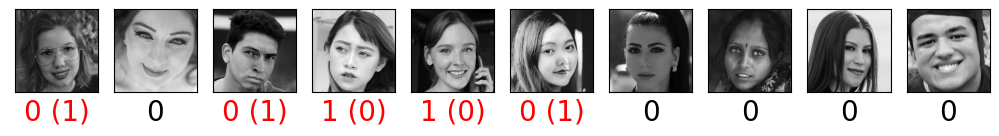

In [13]:
sigmoid = nn.Sigmoid()
x_test, y_test,_ = next(iter(test_data_loader))
transform_ = transforms.Resize(size = (30,30))
x_t = transform_(x_test)
y_pred = model_trained(x_t.squeeze().view(10,-1))
y_test = y_test.numpy().astype(int)
y_pred = torch.round(sigmoid(y_pred)).squeeze(1).detach().numpy().astype(int)
x_test = x_test.squeeze().numpy()
plot_images(x_test, y_test, range(0,10), columns=12, x_size=1, y_size=1, y_pred=y_pred)

In [35]:
x_t.shape

torch.Size([10, 1, 30, 30])

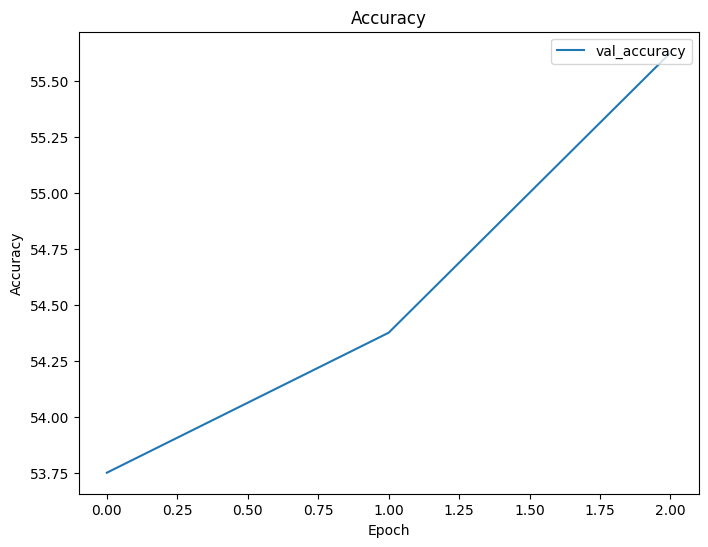

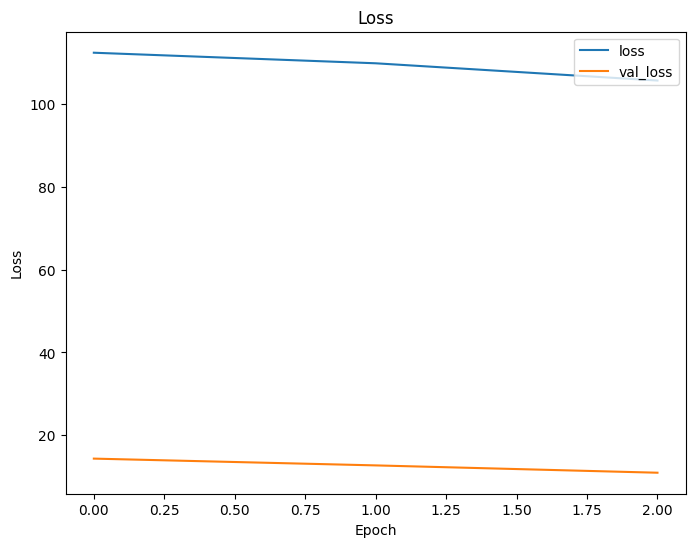

In [14]:
plot_history(history)

In [42]:
def extract_mlp_layer(model, data_loader, len_dataset):
    images_tot = torch.empty((len_dataset, 100), dtype=torch.float)
    labels_im_tot = torch.empty(len_dataset, dtype=torch.float)
    labels_token = torch.empty(len_dataset, dtype=torch.float)
    transform = transforms.Resize(size = (30,30))
    model.to("cpu")
    model.eval()
    with torch.no_grad():
        for ib, (images, labels, label_to_token) in enumerate(data_loader):
            indices_b = torch.arange(ib*batch_size, (ib+1)*batch_size)
            #print(indices_b, labels.shape)
            labels_im_tot[indices_b] = labels.float()
            labels_token[indices_b] = label_to_token.float()
            images = transform(images)
            images = images.reshape(images.shape[0], -1)
            out = model(images)
            in_im_vec = activation["hidden3"].reshape(batch_size, -1)
            images_tot[indices_b, :] = in_im_vec

    images_tot = images_tot.numpy()
    labels_im_tot = labels_im_tot.numpy()
    labels_token = labels_token.numpy()
    print('Size of vectorized input images:', images_tot.shape)
    print('Size of the tensor storing labels:', labels_im_tot.shape)
    return images_tot, labels_im_tot, labels_token

In [59]:
activation = {}
mlp_layer = model_trained.hidden3.register_forward_hook(getActivation('hidden3'))

In [60]:
batch_size=10
X, y,labels_token = extract_mlp_layer(model_trained, train_data_loader, len(train_data))

Size of vectorized input images: (1469, 100)
Size of the tensor storing labels: (1469,)


In [61]:
X = TSNE(perplexity=45,n_components=2, init='pca', learning_rate='auto').fit_transform(X)

/mnt/c/Master2/DeepLearning/dl-env/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:996: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


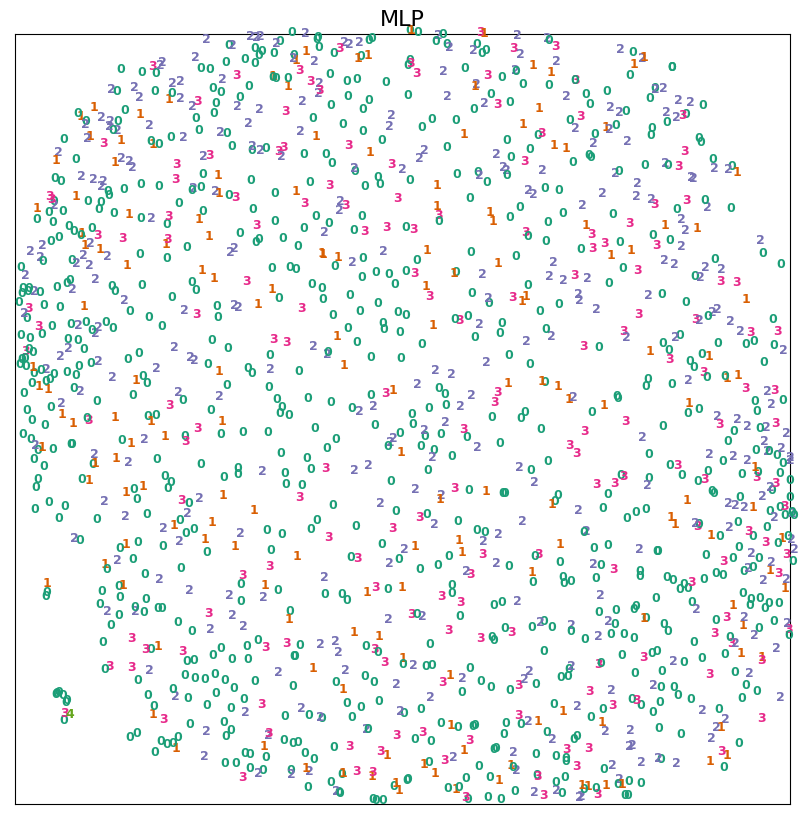

In [62]:
plot_embeddings(X, labels_token, "MLP")

In [63]:
class CNN(nn.Module):
    def __init__(self, num_channels1=16, num_channels2=32, num_classes=1):
        super(CNN, self).__init__()
        self.conv_block1 = nn.Sequential(nn.Conv2d(in_channels=1, out_channels= num_channels1, kernel_size=5, padding=2),
                           nn.ReLU(),
                           #nn.BatchNorm2d(num_channels1, affine=False),
                           nn.MaxPool2d(kernel_size=2))
        
        self.conv_block2 = nn.Sequential(nn.Conv2d(num_channels1, num_channels2, kernel_size=5, padding=2),
                           nn.ReLU(),
                           #nn.BatchNorm2d(num_channels2,affine=False),
                           nn.MaxPool2d(kernel_size=2))
        self.fc = nn.Linear(32*7*7, num_classes)

    def forward(self, x):
        x = self.conv_block1(x)
        x = self.conv_block2(x)
        out = self.fc(x.view(-1, 32*7*7))
        return out

In [65]:
cnn_model = CNN()
cnn_model = cnn_model.to(device)
print(next(cnn_model.parameters()).is_cuda)

False


In [66]:
def training_cnn_classifier(model, train_dataloader, valid_dataloader, num_epochs,
                            loss_fn, learning_rate, verbose=True):

    model_tr = copy.deepcopy(model)
    model_tr = model_tr.to(device)
    
    model_tr.train()
    optimizer = torch.optim.SGD(model_tr.parameters(), lr=learning_rate)
    scheduler = lr_scheduler.ExponentialLR(optimizer, gamma=0.9)
    # Initialize a list to record the training loss over epochs
    loss_all_epochs = []
    valid_acc, valid_loss = [], []
    transform = transforms.Resize(size = (30,30))
    # Training loop
    for epoch in range(num_epochs):
        # Initialize the training loss for the current epoch
        loss_current_epoch = 0
        
        # Iterate over batches using the dataloader
        for batch_index, (images, labels,_) in enumerate(train_dataloader):
            images = transform(images).to(device)
            labels = labels.to(device)
            y_pred = model_tr(images)
            l = loss_fn(y_pred, labels.view(-1, 1))
            optimizer.zero_grad()
            l.backward()
            loss_current_epoch += l.item()
            optimizer.step() #update parameters

        
        scheduler.step() # Update the learning rate
        loss_all_epochs.append(loss_current_epoch)
        val_loss, accuracy = eval_cnn_classifier(model_tr, 
                                                 valid_dataloader,
                                                 loss_fn)
        valid_loss.append(val_loss)
        valid_acc.append(accuracy)
        if verbose:
            # print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, loss_current_epoch))
            print(f"\nEpoch [{epoch+1}/{num_epochs}]"
                  f"\nTrain loss: {loss_current_epoch:.5f} | "
                  f"Test loss: {val_loss:.5f} | Test acc: {accuracy:.2f}%\n")
        
    return model_tr, {'loss': loss_all_epochs,'val_loss': valid_loss, 'val_accuracy': valid_acc}

def eval_cnn_classifier(model, eval_dataloader,loss_fn):
    sigmoid = nn.Sigmoid()
    # Set the model in evaluation mode
    model.eval() 
    transform = transforms.Resize(size = (30,30))
    # In test phase, we don't need to compute gradients (for memory efficiency)
    with torch.no_grad():
        # initialize the total and correct number of labels to compute the accuracy
        correct,loss = 0, 0
        total = 0
        for images, labels,_ in eval_dataloader:
            images = transform(images).to(device)
            labels = labels.to(device)
            y_predicted = model(images)
            label_predicted = torch.round(sigmoid(y_predicted)).squeeze(1) #y_preds = torch.round(torch.sigmoid(model_3(X_test))).squeeze()
            l =loss_fn(y_predicted, labels.unsqueeze(1).to(device))
            loss += l.item()
            total += labels.size(0)
            correct += (label_predicted == labels).sum().item()
    
    accuracy = 100 * correct / total
    
    return loss, accuracy

In [67]:
model_cnn = CNN()
model_cnn.to(device)
num_epochs = 5
learning_rate = 0.3
loss_fn = nn.BCEWithLogitsLoss()
model_cnn, history= training_cnn_classifier(model_cnn, train_data_loader,valid_data_loader, num_epochs,
                            loss_fn, learning_rate, verbose=True)


Epoch [1/5]
Train loss: 103.08660 | Test loss: 11.05712 | Test acc: 50.62%


Epoch [2/5]
Train loss: 100.49806 | Test loss: 10.74925 | Test acc: 58.75%


Epoch [3/5]
Train loss: 98.91314 | Test loss: 11.00932 | Test acc: 55.00%


Epoch [4/5]
Train loss: 97.80102 | Test loss: 10.95132 | Test acc: 56.25%


Epoch [5/5]
Train loss: 97.78562 | Test loss: 10.55692 | Test acc: 60.00%



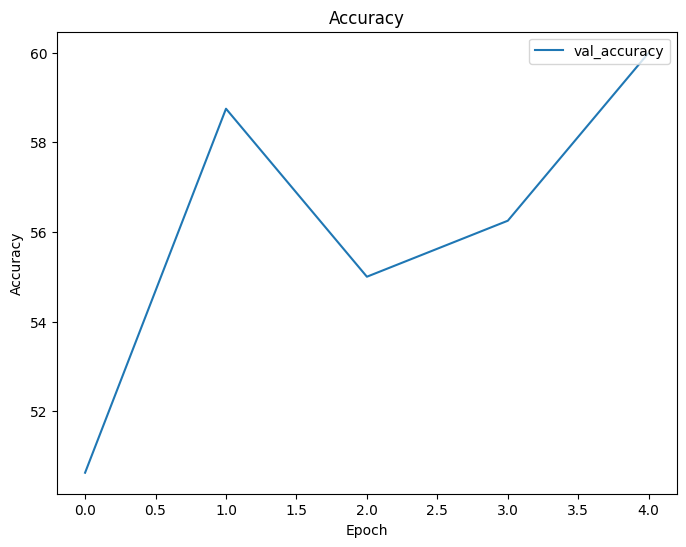

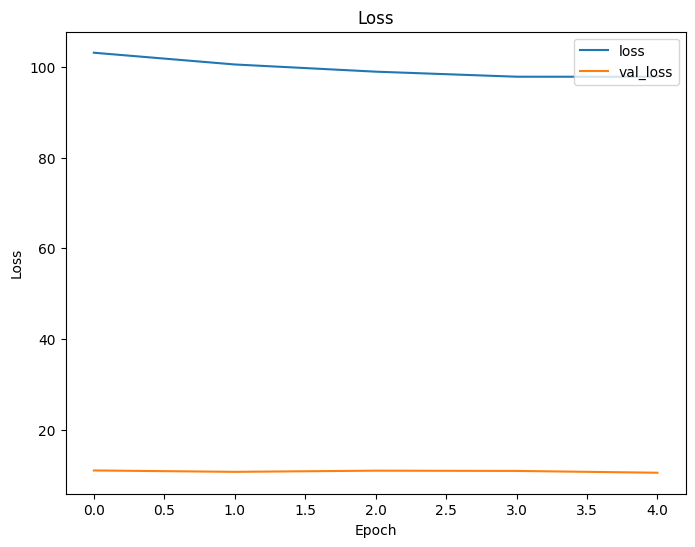

In [68]:
plot_history(history)

In [71]:
eval_cnn_classifier(model_cnn, test_data_loader,loss_fn)

(26.44459080696106, 60.75)

In [72]:
activation = {}
cnn_layer = model_cnn.conv_block2.register_forward_hook(getActivation('conv_block2'))

In [73]:
batch_size = 10
len_dataset=len(train_data)
transform = transforms.Resize(size = (30,30))
images_tot = torch.empty((len_dataset, 32*49), dtype=torch.float)
labels_im_tot = torch.empty(len_dataset, dtype=torch.float)
labels_token = torch.empty(len_dataset, dtype=torch.float)
model_cnn.to('cpu')
model_cnn.eval()
with torch.no_grad():
    for ib, (images, labels,label_to_tok) in enumerate(train_data_loader):
        images = transform(images)
        indices_b = torch.arange(ib*batch_size, (ib+1)*batch_size)
        labels_token[indices_b] = label_to_tok.float()
        labels_im_tot[indices_b] = labels.float()
        out = model_cnn(images)
        in_im_vec = activation["conv_block2"].reshape(batch_size, -1)
        images_tot[indices_b, :] = in_im_vec

images_tot = images_tot.numpy()
labels_im_tot = labels_im_tot.numpy()
labels_token = labels_token.numpy()
print('Size of vectorized input images:', images_tot.shape)
print('Size of the tensor storing labels:', labels_im_tot.shape)

Size of vectorized input images: (1469, 1568)
Size of the tensor storing labels: (1469,)


/mnt/c/Master2/DeepLearning/dl-env/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:996: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(
/mnt/c/Master2/DeepLearning/dl-env/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:2583: UserWarning: n_quantiles (1000) is greater than the total number of samples (500). n_quantiles is set to n_samples.
  warnings.warn(


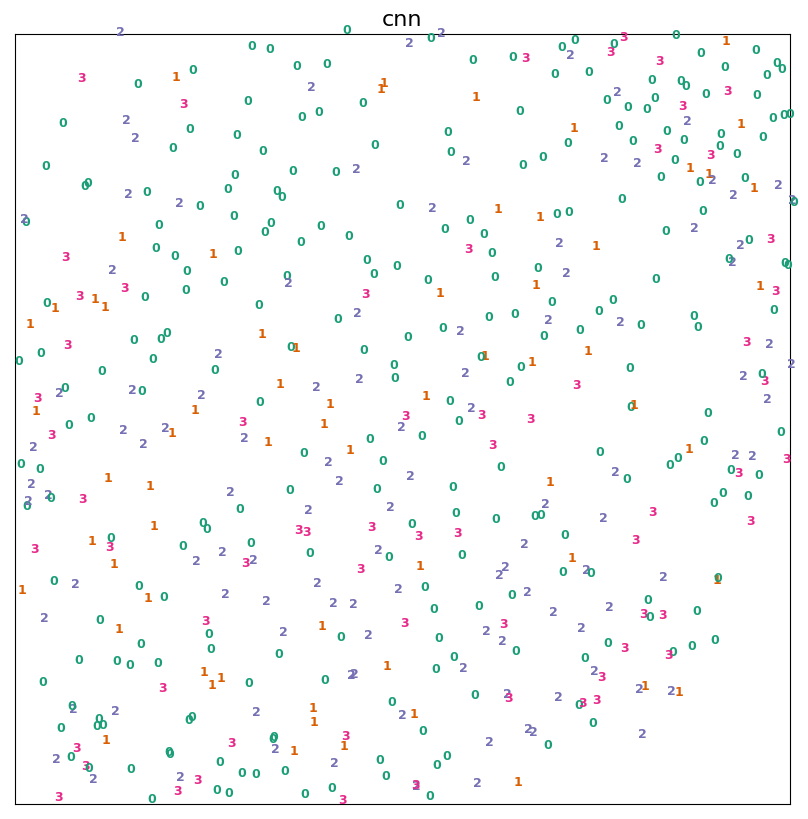

In [74]:
X = TSNE(n_components=2, init='pca', learning_rate='auto',n_iter=2000).fit_transform(images_tot[:500,:])
plot_embeddings(X, labels_token[:500], "cnn")

/mnt/c/Master2/DeepLearning/dl-env/lib/python3.10/site-packages/umap/umap_.py:125: UserWarning: A few of your vertices were disconnected from the manifold.  This shouldn't cause problems.
Disconnection_distance = inf has removed 26352 edges.
It has only fully disconnected 9 vertices.
Use umap.utils.disconnected_vertices() to identify them.
  warn(
/mnt/c/Master2/DeepLearning/dl-env/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:259: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy shou

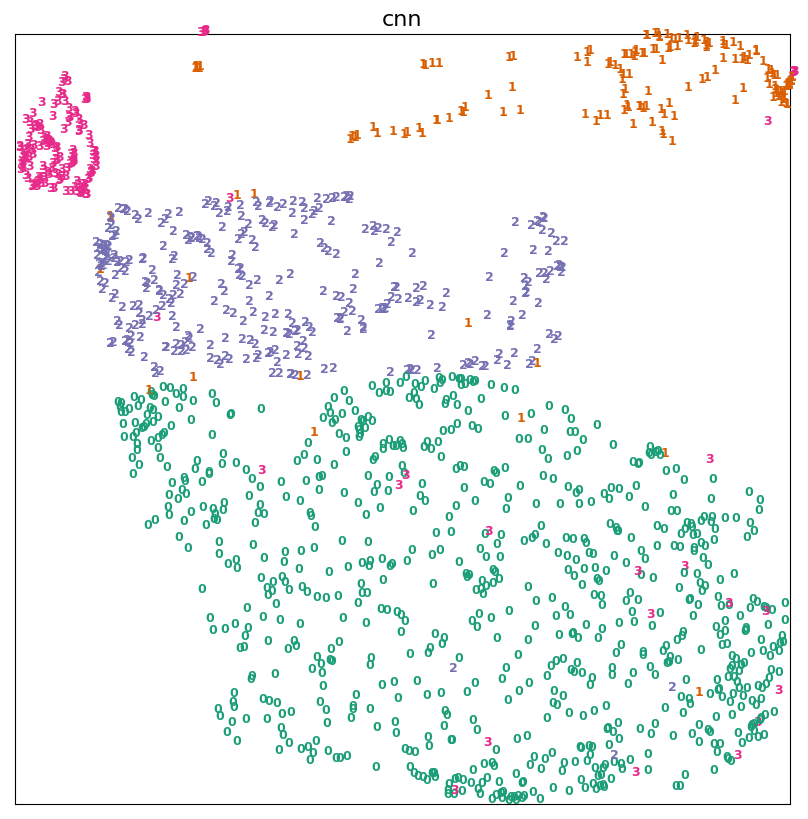

In [76]:
standard_embedding = umap.UMAP(random_state=42).fit_transform(images_tot,
                                                              y=labels_token.astype(int)
                                                             )
plot_embeddings(standard_embedding, labels_token, "cnn")

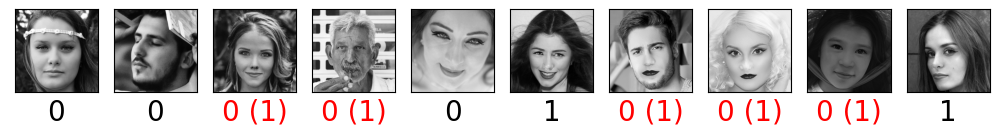

In [85]:
sigmoid = nn.Sigmoid()
x_test, y_test,_ = next(iter(test_data_loader))
transform_ = transforms.Resize(size = (30,30))
x_t = transform_(x_test)
y_pred = model_cnn(x_t)
y_test = y_test.numpy().astype(int)
y_pred = torch.round(sigmoid(y_pred)).squeeze(1).detach().numpy().astype(int)
x_test = x_test.squeeze().numpy()
plot_images(x_test, y_test, range(0,10), columns=12, x_size=1, y_size=1, y_pred=y_pred)

In [78]:
def plot_confusion_matrix(y_true,y_pred,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True,
                          figsize=(10, 8),
                          digit_format='{:0.2f}'):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    cm = confusion_matrix( y_true,y_pred, normalize=None, labels=target_names)
    
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=figsize)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=90)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, digit_format.format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

In [81]:
transform_ = transforms.Resize(size = (30,30))
true_labels, pred_labels = [], []
with torch.no_grad():

    for x, y,_ in test_data_loader:
        x_t = transform_(x)
        y_pred = model_cnn(x_t)
        true_labels += y.tolist()
        prediction = torch.round(sigmoid(y_pred)).squeeze(1).numpy().tolist()
        pred_labels += prediction

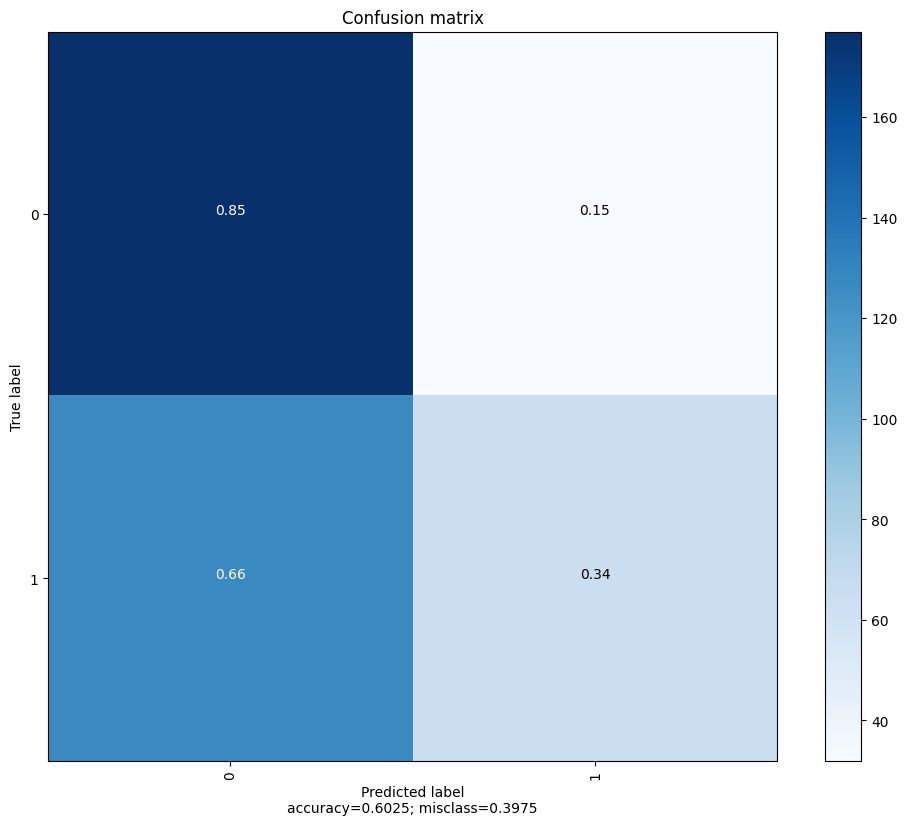

In [82]:
plot_confusion_matrix(y_true=np.array(true_labels),y_pred=np.array(pred_labels),
                          target_names=[0, 1])